<a target="_blank" href="https://colab.research.google.com/github/FlyingPumba/circuits-benchmark/blob/main/DEMO_InterpBench.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### Code to setup InterpBench

### Load model from InterpBench

In [1]:
import math
!git lfs install
!git clone https://huggingface.co/cybershiptrooper/InterpBench

Updated Git hooks.
Git LFS initialized.
Cloning into 'InterpBench'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (205/205), done.
remote: Total 225 (delta 71), reused 0 (delta 0), pack-reused 4 (from 1)
Receiving objects: 100% (225/225), 385.53 KiB | 1.85 MiB/s, done.
Resolving deltas: 100% (71/71), done.
 Filtering content:  40% (22/55), 1.11 MiB | 372.00 KiB/sFiltering content:  50% (28/55), 1.17 MiB | 254.00 KiB/sFiltering content:  58% (32/55), 1.17 MiB | 254.00 KiB/sFiltering content:  70% (39/55), 1.18 MiB | 191.00 KiB/sFiltering content:  78% (43/55), 1.19 MiB | 165.00 KiB/sFiltering content:  83% (46/55), 1.19 MiB | 165.00 KiB/sFiltering content:  98% (54/55), 1.19 MiB | 139.00 KiB/sFiltering content: 100% (55/55), 82.13 MiB | 2.99 MiB/s, done.


In [3]:
%load_ext autoreload
%autoreload 2
import pickle
import torch
from transformer_lens import HookedTransformerConfig, HookedTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
# fit a multi-gaussian distribution to the activations
from sklearn.mixture import GaussianMixture

def get_log_likelihood_results(activations, d_model):
    gmm = GaussianMixture(n_components=d_model, covariance_type='full')
    gmm.fit(activations)
    
    # get the log likelihood of the activations under the fitted distribution
    mean_activations_log_likelihood = gmm.score_samples(activations).mean().item()
    # print(f"Mean log likelihood: {mean_log_likelihood}")
    
    # get the probability of the mean vector under the fitted distribution
    mean_vector = activations.mean(axis=0).reshape(1, -1)
    mean_vector_log_likelihood = gmm.score_samples(mean_vector).item()
    # print(f"Log likelihood of mean vector: {gmm.score_samples(mean_vector).item()}")
    # print(f"Predicted probability of mean vector: {gmm.predict_proba(mean_vector)}")
    # print(f"Akaike information criterion on mean vector: {gmm.aic(mean_vector)}")
    # print(f"Bayesian information criterion on mean vector: {gmm.bic(mean_vector)}")
    
    # get the probability of the zero vector under the fitted distribution
    zero_vector = torch.zeros(d_model).reshape(1, -1).numpy()
    zero_vector_log_likelihood = gmm.score_samples(zero_vector).item()
    # print(f"Log likelihood of zero vector: {gmm.score_samples(zero_vector).item()}")
    # print(f"Predicted probability of zero vector: {gmm.predict_proba(zero_vector)}")
    # print(f"Akaike information criterion on zero vector: {gmm.aic(zero_vector)}")
    # print(f"Bayesian information criterion on zero vector: {gmm.bic(zero_vector)}")
    
    return zero_vector_log_likelihood, mean_vector_log_likelihood, mean_activations_log_likelihood

In [123]:
import pandas as pd

node_stats = pd.read_csv("/home/ivan/src/circuits-benchmark/notebooks/siit_node_stats_all_cases.csv")
node_stats

,run,node,status,resample_ablate_effect,zero_ablate_effect,norm_cache,norm_std,grad_norm,grad_std
0,11,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.000000,0.000,1.262980,0.119411,8.499493e-13,3.875514e-14
1,11,"blocks.0.attn.hook_result, head 1",not_in_circuit,0.000000,0.000,0.799124,0.081348,8.499493e-13,3.875514e-14
2,11,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.000000,0.000,0.338909,0.015247,8.499493e-13,3.875514e-14
3,11,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.000000,0.000,0.890073,0.077784,8.499493e-13,3.875514e-14
4,11,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.000000,0.000,68.908388,8.781318,1.294538e-14,5.751065e-16
...,...,...,...,...,...,...,...,...,...
165,8,"blocks.1.attn.hook_result, head 2",not_in_circuit,0.001137,0.000,198.155608,31.158730,0.000000e+00,1.228670e-25
166,8,"blocks.1.attn.hook_result, head 3",not_in_circuit,0.000000,0.000,121.960837,18.115889,0.000000e+00,1.228670e-25
167,8,blocks.1.mlp.hook_post,not_in_circuit,0.016370,0.000,735.897600,95.376083,0.000000e+00,3.470025e-26
168,8,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.000000,0.000,1.801120,0.390171,0.000000e+00,3.407970e-24


In [124]:
from circuits_benchmark.utils.get_cases import get_cases


# load df for zero ablation effects on all nodes
def fill_log_likelihood_all_nodes(task_idx):
    print(f"Processing case {task_idx}")

    # Load model from InterpBench
    dir_name = f"InterpBench/{task_idx}"
    cfg_dict = pickle.load(open(f"{dir_name}/ll_model_cfg.pkl", "rb"))
    cfg = HookedTransformerConfig.from_dict(cfg_dict)
    cfg.device = "cpu"
    siit_model = HookedTransformer(cfg)
    weights = torch.load(f"{dir_name}/ll_model.pth", map_location="cpu")
    siit_model.load_state_dict(weights)
    
    # turn off grads
    siit_model.eval()
    siit_model.requires_grad_(False)
    
    task = get_cases(indices=[str(task_idx)])[0]
    data = task.get_clean_data(min_samples=1_000, max_samples=1_000)
    logits, cache = siit_model.run_with_cache(data.get_inputs())
    
    for node_name in node_stats[node_stats["run"] == task_idx]["node"]:       
        if "attn" in node_name:
            hook_name, head_idx = node_name.split(", head ")
            print(f"Processing head {head_idx} of {hook_name}")
            activations = cache[hook_name][:, :, int(head_idx)] # shape: [batch, pos, d_model]
        else:
            hook_name = node_name
            print(f"Processing {hook_name}")
            activations = cache[hook_name] # shape: [batch, pos, d_model]
        
        activations = activations.reshape(-1, siit_model.cfg.d_model) # reshape to [batch * pos, d_model]    
        activations = activations.detach().numpy()
        zero_log_likelihood, mean_log_likelihood, mean_activations_log_likelihood = get_log_likelihood_results(activations, siit_model.cfg.d_model)
    
        node_stats.loc[(node_stats["run"] == task_idx) & (node_stats["node"] == node_name), "zero_vector_log_likelihood"] = zero_log_likelihood
        node_stats.loc[(node_stats["run"] == task_idx) & (node_stats["node"] == node_name), "mean_vector_log_likelihood"] = mean_log_likelihood
        node_stats.loc[(node_stats["run"] == task_idx) & (node_stats["node"] == node_name), "mean_activations_log_likelihood"] = mean_activations_log_likelihood

In [125]:
# add a column to node_stats for zero vector log likelihood
node_stats["zero_vector_log_likelihood"] = None
node_stats["mean_vector_log_likelihood"] = None
node_stats["mean_activations_log_likelihood"] = None

for task_idx in node_stats["run"].unique():
    fill_log_likelihood_all_nodes(task_idx)

Processing case 11
Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing blocks.0.mlp.hook_post
Processing head  0 of blocks.1.attn.hook_result


Processing case 13


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing blocks.0.mlp.hook_post
Processing blocks.1.mlp.hook_post


Processing case 18


Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing blocks.0.mlp.hook_post
Processing blocks.1.mlp.hook_post


Processing case 19


Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing head  0 of blocks.0.attn.hook_result
Processing blocks.0.mlp.hook_post
Processing case 20
Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing blocks.0.mlp.hook_post


Processing case 21


Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.2.attn.hook_result
Processing blocks.3.mlp.hook_post
Processing head  3 of blocks.3.attn.hook_result
Processing head  2 of blocks.3.attn.hook_result
Processing head  1 of blocks.3.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.2.attn.hook_result
Processing head  3 of blocks.2.attn.hook_result
Processing head  0 of blocks.2.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing blocks.0.mlp.hook_post
Processing head  0 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing blocks.2.mlp.hook_post
Processing head  0 of blocks.3.attn.hook_result


Processing case 26


Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing blocks.0.mlp.hook_post
Processing case 29
Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing blocks.0.mlp.hook_post
Processing case 3
Processing head  0 of blocks.0.attn.hook_result
Processing 

Processing case 4


Processing head  0 of blocks.0.attn.hook_result
Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.0.mlp.hook_post
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post


Processing case 8


Processing head  1 of blocks.0.attn.hook_result
Processing head  2 of blocks.0.attn.hook_result
Processing head  3 of blocks.0.attn.hook_result
Processing head  0 of blocks.1.attn.hook_result
Processing head  1 of blocks.1.attn.hook_result
Processing head  2 of blocks.1.attn.hook_result
Processing head  3 of blocks.1.attn.hook_result
Processing blocks.1.mlp.hook_post
Processing head  0 of blocks.0.attn.hook_result
Processing blocks.0.mlp.hook_post


In [136]:
# make a new column that is the difference between mean_vector_log_likelihood and zero_vector_log_likelihood
node_stats["mean_zero_diff"] = node_stats["mean_activations_log_likelihood"] - node_stats["zero_vector_log_likelihood"]

# dump to disk
node_stats.to_csv("/home/ivan/src/circuits-benchmark/notebooks/siit_node_stats_all_cases_modified.csv", index=False)

In [140]:
node_stats[(node_stats["status"] == "not_in_circuit") & (node_stats["zero_ablate_effect"] > 0)][["run", "node", "status", "zero_ablate_effect", "zero_vector_log_likelihood", "mean_vector_log_likelihood", "mean_activations_log_likelihood", "mean_zero_diff"]]

,run,node,status,zero_ablate_effect,zero_vector_log_likelihood,mean_vector_log_likelihood,mean_activations_log_likelihood,mean_zero_diff
7,11,blocks.1.mlp.hook_post,not_in_circuit,0.113000,15.920452,-47622266.560073,22.758616,6.838164
20,18,"blocks.0.attn.hook_result, head 2",not_in_circuit,0.112000,-402590.425834,-489.436256,128.642185,402719.068019
21,18,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.095000,-14823.390894,-37.48277,116.811201,14940.202095
33,19,"blocks.1.attn.hook_result, head 0",not_in_circuit,0.066667,82.18182,16.443214,163.3202,81.138379
34,19,"blocks.1.attn.hook_result, head 1",not_in_circuit,0.066667,-935.739106,-7016.613108,185.123366,1120.862472
37,19,blocks.1.mlp.hook_post,not_in_circuit,0.066667,-81.391384,-228807220.268377,59.953156,141.34454
48,20,blocks.1.mlp.hook_post,not_in_circuit,0.100000,-2058.617683,-40133988153.660042,33.140637,2091.75832
50,21,"blocks.0.attn.hook_result, head 0",not_in_circuit,0.007007,-396.79579,251.326259,271.874951,668.670741
56,21,"blocks.0.attn.hook_result, head 1",not_in_circuit,0.005005,15.954415,251.788291,273.052422,257.098007
63,21,"blocks.0.attn.hook_result, head 3",not_in_circuit,0.107107,-1028.741637,236.376307,273.498099,1302.239736


<Axes: xlabel='Activations mean Log Likelihood and Zero vector LL difference', ylabel='Zero ablation effect (nodes not in circuit)'>

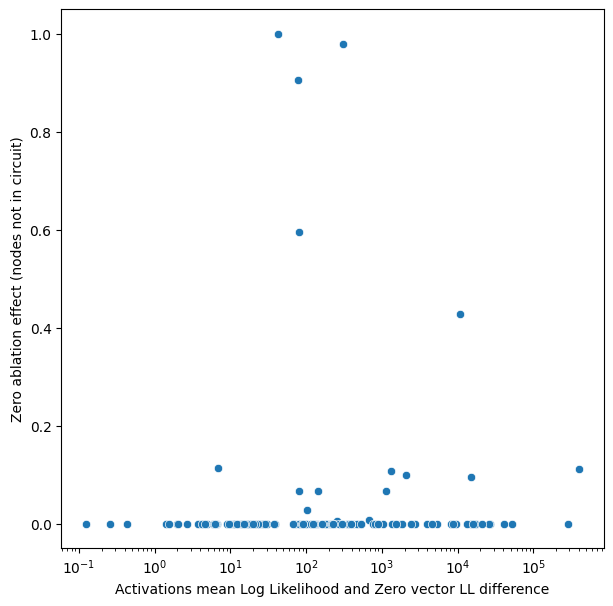

In [166]:
# plot the correlation between mean_zero_diff and zero_ablate_effect
import matplotlib.pyplot as plt
import seaborn as sns

# make a df with only the nodes that are not in the circuit, and zero_ablate_effect is greater than 0
node_stats_filtered = node_stats[(node_stats["status"] == "not_in_circuit")]

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")

ax.set_xlabel("Activations mean Log Likelihood and Zero vector LL difference")
ax.set_ylabel("Zero ablation effect (nodes not in circuit)")

sns.scatterplot(data=node_stats_filtered,
                ax=ax,
                x="mean_zero_diff",
                y="zero_ablate_effect")

In [13]:
from circuits_benchmark.benchmark.cases.case_3 import Case3

task = Case3()
task_idx = task.get_name()
tracr_model = task.get_hl_model()

In [8]:
def run_attn_head_ablation(layer, head_index):
    cache_key = f"blocks.{layer}.attn.hook_result"
    def za_hook_fn(hook_point_out, hook):
        # hook_point_out has shape [batch pos head_index d_model]
        hook_point_out[:,:, head_index] = 0
        return hook_point_out
    
    
    zero_ablation_logits = siit_model.run_with_hooks(encoded_inputs, fwd_hooks=[(cache_key, za_hook_fn)])
    zero_ablation_mse = t.nn.functional.l1_loss(logits, zero_ablation_logits)
    print(f"Zero ablation MSE for {cache_key}[{head_index}]: {zero_ablation_mse}")
    
    corrupted_data = task.get_corrupted_data(count=None)
    encoded_corrupted_inputs = t.stack([t.tensor(tracr_model.tracr_input_encoder.encode(x)) for x in corrupted_data.get_inputs()])
    _, corrupted_cache = siit_model.run_with_cache(encoded_corrupted_inputs)
    
    def ra_hook_fn(hook_point_out, hook):
        # hook_point_out has shape [batch pos head_index d_model]
        hook_point_out[:,:, head_index] = corrupted_cache[cache_key][:,:, head_index]
        return hook_point_out
    
    
    resample_ablation_logits = siit_model.run_with_hooks(encoded_inputs, fwd_hooks=[(cache_key, ra_hook_fn)])
    resample_ablation_mse = t.nn.functional.l1_loss(logits, resample_ablation_logits)
    print(f"Resample ablation MSE for {cache_key}[{head_index}]: {resample_ablation_mse}")

In [9]:
def run_mlp_ablation(layer):
    cache_key = f"blocks.{layer}.hook_mlp_out"
    def za_hook_fn(hook_point_out, hook):
        # hook_point_out has shape [batch, pos, d_model]
        hook_point_out = 0
        return hook_point_out
    
    
    zero_ablation_logits = siit_model.run_with_hooks(encoded_inputs, fwd_hooks=[(cache_key, za_hook_fn)])
    zero_ablation_mse = t.nn.functional.l1_loss(logits, zero_ablation_logits)
    print(f"Zero ablation MSE for {cache_key}: {zero_ablation_mse}")
    
    corrupted_data = task.get_corrupted_data(count=None)
    encoded_corrupted_inputs = t.stack([t.tensor(tracr_model.tracr_input_encoder.encode(x)) for x in corrupted_data.get_inputs()])
    _, corrupted_cache = siit_model.run_with_cache(encoded_corrupted_inputs)
    
    def ra_hook_fn(hook_point_out, hook):
        # hook_point_out has shape [batch, pos, d_model]
        hook_point_out = corrupted_cache[cache_key]
        return hook_point_out
    
    
    resample_ablation_logits = siit_model.run_with_hooks(encoded_inputs, fwd_hooks=[(cache_key, ra_hook_fn)])
    resample_ablation_mse = t.nn.functional.l1_loss(logits, resample_ablation_logits)
    print(f"Resample ablation MSE for {cache_key}: {resample_ablation_mse}")

In [10]:
run_attn_head_ablation(1, 0)
run_attn_head_ablation(1, 1)
run_attn_head_ablation(1, 2)
run_mlp_ablation(0)
run_mlp_ablation(1)

Zero ablation MSE for blocks.1.attn.hook_result[0]: 0.004551108460873365
Resample ablation MSE for blocks.1.attn.hook_result[0]: 0.0035946995485574007
Zero ablation MSE for blocks.1.attn.hook_result[1]: 0.0006424558232538402
Resample ablation MSE for blocks.1.attn.hook_result[1]: 0.0006705792620778084
Zero ablation MSE for blocks.1.attn.hook_result[2]: 0.22658303380012512
Resample ablation MSE for blocks.1.attn.hook_result[2]: 0.23703637719154358
Zero ablation MSE for blocks.0.hook_mlp_out: 0.22458796203136444
Resample ablation MSE for blocks.0.hook_mlp_out: 0.23467989265918732
Zero ablation MSE for blocks.1.hook_mlp_out: 0.011983295902609825
Resample ablation MSE for blocks.1.hook_mlp_out: 0.0013806588249281049


In [8]:
cache.keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.hook_q_input', 'blocks.0.hook_k_input', 'blocks.0.hook_v_input', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_q_input', 'blocks.1.hook_k_input', 'blocks.1.hook_v_input', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_result', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.hook_mlp_in', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post'])

In [9]:
tracr_model.tracr_input_encoder.encoding_map

{'BOS': 0, 'PAD': 1, 'a': 2, 'b': 3, 'c': 4, 'x': 5}

In [10]:
first_input = encoded_inputs[:1]
first_input

tensor([[0, 5, 4, 3, 2]])

In [11]:
encoded_inputs[:5]

tensor([[0, 5, 4, 3, 2],
        [0, 2, 2, 3, 4],
        [0, 3, 2, 5, 5],
        [0, 5, 2, 5, 4],
        [0, 3, 5, 3, 3]])

In [12]:
data.get_correct_outputs()[:5]

0    [BOS, 1.0, 0.5, 0.3333333333333333, 0.25]
1                    [BOS, 0.0, 0.0, 0.0, 0.0]
2     [BOS, 0.0, 0.0, 0.3333333333333333, 0.5]
3     [BOS, 1.0, 0.5, 0.6666666666666666, 0.5]
4    [BOS, 0.0, 0.5, 0.3333333333333333, 0.25]
Name: correct_output, dtype: object

In [13]:
torch.set_printoptions(linewidth=240)
embedings = siit_model.W_E[first_input, :]
embedings

tensor([[[-0.1863, -0.4106,  0.0083, -0.1364,  0.1508,  0.1645, -0.0631, -0.3943,  0.0615, -0.2882,  0.1572,  0.1283],
         [-0.3320, -0.0315, -0.2762, -0.0480,  0.1436, -0.1237, -0.4023, -0.0514, -0.1735, -0.0327,  0.1446,  0.1263],
         [-0.0719,  0.1999,  0.2309, -0.0204, -0.0252,  0.0218,  0.2017, -0.1103,  0.3006,  0.4999,  0.2332,  0.2836],
         [ 0.0607,  0.0399,  0.2058,  0.0599,  0.0252,  0.1725, -0.0240,  0.0351,  0.1596,  0.4550, -0.2522, -0.1567],
         [ 0.1832, -0.1040,  0.0473, -0.0218,  0.1812,  0.3419,  0.2472, -0.1109,  0.0369,  0.2031, -0.1579,  0.0327]]])

In [14]:
(cache["blocks.0.hook_resid_mid"][0] - cache["hook_embed"][0]).norm(dim=-1)

tensor([1.5939, 1.3156, 1.1161, 1.2436, 1.0572])

In [15]:
(cache["blocks.0.hook_resid_post"][0] - cache["blocks.0.hook_resid_mid"][0]).norm(dim=-1)

tensor([1.9588, 0.7172, 1.5876, 1.8697, 1.5818])

In [16]:
cache["blocks.0.hook_resid_post"][0] - cache["blocks.0.hook_resid_mid"][0]

tensor([[ 0.2918, -0.6445,  0.7137,  0.6213, -0.6032,  0.0036,  0.5483,  1.1895,  0.4886, -0.0678, -0.2915,  0.1826],
        [-0.1515, -0.0453, -0.2092,  0.1665, -0.2111, -0.0314,  0.1151,  0.2950,  0.3682,  0.0967,  0.3147, -0.1675],
        [-0.0058, -0.4506, -0.3416,  0.1545, -0.4283, -0.4241,  0.3910,  0.8233, -0.6463,  0.6947,  0.0921,  0.2718],
        [-0.0361, -0.3801, -0.4527,  0.3399, -0.5141, -0.5427,  0.4832,  0.8465, -0.6728,  0.9068,  0.1813,  0.4614],
        [-0.1740, -0.2777, -0.2476,  0.4178, -0.4359, -0.3044,  0.5104,  0.6961, -0.5951,  0.8477, -0.0517,  0.2358]])

In [17]:
cache["blocks.1.hook_attn_out"][0] - cache["blocks.1.hook_resid_pre"][0]

tensor([[ 0.0189,  2.4028, -1.8642, -0.7487,  0.3668, -0.2104, -1.4478, -1.0541, -0.9222,  0.4116,  0.1399, -0.7525],
        [ 0.5277,  1.1746,  0.2818, -0.5515,  0.3846, -0.1233, -0.5462, -0.6967, -0.8065,  0.0914, -0.3044,  0.4249],
        [-0.0807,  0.7819, -0.3074, -0.0901,  0.2259,  0.3952, -0.9733, -0.3761,  0.0352, -1.6549, -0.2322, -0.2339],
        [-0.0541,  0.7052, -0.4207, -0.0376,  0.1954,  0.3023, -0.7217, -0.3674,  0.1991, -1.8862,  0.2138, -0.0231],
        [ 0.0861,  0.8114, -0.7414, -0.0173,  0.3656, -0.1078, -0.8867, -0.3019,  0.2947, -1.6953,  0.1654, -0.0906]])

In [18]:
cache["blocks.1.hook_resid_pre"][0] @ siit_model.W_U + siit_model.b_U

tensor([[-0.4782],
        [-0.1068],
        [-0.3199],
        [-0.3174],
        [-0.3191]])

In [19]:
cache["blocks.1.hook_attn_out"][0] @ siit_model.W_U + siit_model.b_U

tensor([[0.6976],
        [0.8279],
        [0.4565],
        [0.2886],
        [0.1984]])

In [20]:
cache["blocks.1.hook_resid_mid"][0] @ siit_model.W_U + siit_model.b_U

tensor([[ 0.1636],
        [ 0.6653],
        [ 0.0809],
        [-0.0846],
        [-0.1765]])

In [21]:
cache["blocks.1.hook_resid_post"][0] @ siit_model.W_U + siit_model.b_U

tensor([[-0.0055],
        [ 0.9985],
        [ 0.4917],
        [ 0.3344],
        [ 0.2381]])

In [65]:
siit_model.W_U

Parameter containing:
tensor([[-0.1169],
        [ 0.4326],
        [ 0.1025],
        [-0.2898],
        [ 0.2668],
        [ 0.1568],
        [ 0.0855],
        [-0.0771],
        [-0.1996],
        [-0.1872],
        [-0.2488],
        [-0.0242]])

In [64]:
siit_model.b_U

Parameter containing:
tensor([0.0558])

In [161]:
from torch import nn

loss_fn = nn.MSELoss()

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)  

    def forward(self, x):
        out = self.linear(x)
        return out

In [162]:
# train a linear probe for Attention in layer 0.
linear_probe_attn_l0 = LinearRegressionModel(siit_model.cfg.d_model, siit_model.cfg.d_model)
optimizer = torch.optim.AdamW(linear_probe_attn_l0.parameters(), lr=0.01)

inputs = cache["blocks.0.hook_resid_pre"].detach()
targets = cache["blocks.0.hook_resid_mid"].detach()

# Remove BOS
# inputs = inputs[:, 1:]
# targets = targets[:, 1:]

for i in range(20000):
    optimizer.zero_grad()
    outputs = linear_probe_attn_l0(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"loss {i}: {loss.item()}")

loss 0: 0.20508615672588348
loss 100: 0.004170928616076708
loss 200: 0.0022333243396133184
loss 300: 0.0016773774987086654
loss 400: 0.00145070964936167
loss 500: 0.0013266901951283216
loss 600: 0.0012448503402993083
loss 700: 0.0011872301110997796
loss 800: 0.001146170194260776
loss 900: 0.001116976491175592
loss 1000: 0.001096320920623839
loss 1100: 0.0010817724978551269
loss 1200: 0.0010715663665905595
loss 1300: 0.0010644373251125216
loss 1400: 0.0010594838531687856
loss 1500: 0.0010560646187514067
loss 1600: 0.0010537218768149614
loss 1700: 0.0010521287331357598
loss 1800: 0.0010510521242395043
loss 1900: 0.0010503280209377408
loss 2000: 0.0010498405899852514
loss 2100: 0.0010495116002857685
loss 2200: 0.0010492880828678608
loss 2300: 0.0010491323191672564
loss 2400: 0.0010490230051800609
loss 2500: 0.001048943609930575
loss 2600: 0.001048885053023696
loss 2700: 0.001048839883878827
loss 2800: 0.0010488048428669572
loss 2900: 0.0010487762046977878
loss 3000: 0.0010487526888027787


In [175]:
# train a linear probe for MLP in layer 0.
linear_probe_mlp_l0 = LinearRegressionModel(siit_model.cfg.d_model, siit_model.cfg.d_model)
optimizer = torch.optim.AdamW(linear_probe_mlp_l0.parameters(), lr=0.01)

inputs = cache["blocks.0.hook_resid_mid"].detach()
targets = cache["blocks.0.hook_resid_post"].detach()

# Remove BOS
# inputs = inputs[:, 1:]
# targets = targets[:, 1:]

for i in range(20000):
    optimizer.zero_grad()
    outputs = linear_probe_mlp_l0(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"loss {i}: {loss.item()}")

loss 0: 0.49386826157569885
loss 100: 0.005997457075864077
loss 200: 0.0026782071217894554
loss 300: 0.0016945251263678074
loss 400: 0.001301352633163333
loss 500: 0.0010661083506420255
loss 600: 0.0008985477034002542
loss 700: 0.0007720822468400002
loss 800: 0.0006734101916663349
loss 900: 0.0005948820034973323
loss 1000: 0.0005319269257597625
loss 1100: 0.0004815490101464093
loss 1200: 0.0004415063594933599
loss 1300: 0.0004099387733731419
loss 1400: 0.0003852295340038836
loss 1500: 0.0003659732756204903
loss 1600: 0.00035097351064905524
loss 1700: 0.00033923942828550935
loss 1800: 0.00032997591188177466
loss 1900: 0.0003225627588108182
loss 2000: 0.0003165287198498845
loss 2100: 0.0003115239960607141
loss 2200: 0.0003072924737352878
loss 2300: 0.00030364980921149254
loss 2400: 0.0003004632599186152
loss 2500: 0.00029763655038550496
loss 2600: 0.00029509965679608285
loss 2700: 0.0002927996392827481
loss 2800: 0.0002906961308326572
loss 2900: 0.0002887565060518682
loss 3000: 0.0002869

In [164]:
# train a linear probe for Attention in layer 1.
linear_probe_attn_l1 = LinearRegressionModel(siit_model.cfg.d_model, siit_model.cfg.d_model)
optimizer = torch.optim.AdamW(linear_probe_attn_l1.parameters(), lr=0.01)

inputs = cache["blocks.1.hook_resid_pre"].detach()
targets = cache["blocks.1.hook_resid_mid"].detach()

# Remove BOS
# inputs = inputs[:, 1:]
# targets = targets[:, 1:]

for i in range(20000):
    optimizer.zero_grad()
    outputs = linear_probe_attn_l1(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"loss {i}: {loss.item()}")

loss 0: 0.4887549579143524
loss 100: 0.012425515800714493
loss 200: 0.007852182723581791
loss 300: 0.005559603217989206
loss 400: 0.004232072737067938
loss 500: 0.003388612763956189
loss 600: 0.0028204245027154684
loss 700: 0.00242306268773973
loss 800: 0.002135277958586812
loss 900: 0.0019181803800165653
loss 1000: 0.0017469297163188457
loss 1100: 0.001606070902198553
loss 1200: 0.001486222492530942
loss 1300: 0.0013817246071994305
loss 1400: 0.0012891083024442196
loss 1500: 0.0012061767047271132
loss 1600: 0.001131480443291366
loss 1700: 0.0010640152031555772
loss 1800: 0.0010030493140220642
loss 1900: 0.0009480156004428864
loss 2000: 0.0008984432206489146
loss 2100: 0.0008539175032638013
loss 2200: 0.000814054103102535
loss 2300: 0.000778485496994108
loss 2400: 0.0007468573749065399
loss 2500: 0.000718823226634413
loss 2600: 0.000694049522280693
loss 2700: 0.0006722146063111722
loss 2800: 0.0006530144019052386
loss 2900: 0.0006361616542562842
loss 3000: 0.0006213903543539345
loss 31

In [165]:
# train a linear probe for MLP in layer 1.
linear_probe_mlp_l1 = LinearRegressionModel(siit_model.cfg.d_model, siit_model.cfg.d_model)
optimizer = torch.optim.AdamW(linear_probe_mlp_l1.parameters(), lr=0.01)

inputs = cache["blocks.1.hook_resid_mid"].detach()
targets = cache["blocks.1.hook_resid_post"].detach()

# Remove BOS
# inputs = inputs[:, 1:]
# targets = targets[:, 1:]

for i in range(20000):
    optimizer.zero_grad()
    outputs = linear_probe_mlp_l1(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"loss {i}: {loss.item()}")

loss 0: 0.4610433876514435
loss 100: 0.008564412593841553
loss 200: 0.0037144694942981005
loss 300: 0.0025120964273810387
loss 400: 0.0020349931437522173
loss 500: 0.0017666617641225457
loss 600: 0.0015957597643136978
loss 700: 0.0014812038280069828
loss 800: 0.0014010394224897027
loss 900: 0.0013422699412330985
loss 1000: 0.0012970821699127555
loss 1100: 0.0012607915559783578
loss 1200: 0.0012305921409279108
loss 1300: 0.0012047869386151433
loss 1400: 0.0011823235545307398
loss 1500: 0.0011625251499935985
loss 1600: 0.0011449340963736176
loss 1700: 0.0011292255949229002
loss 1800: 0.0011151577346026897
loss 1900: 0.0011025406420230865
loss 2000: 0.0010912216966971755
loss 2100: 0.001081072841770947
loss 2200: 0.0010719834826886654
loss 2300: 0.0010640242835506797
loss 2400: 0.0010566061828285456
loss 2500: 0.001050151651725173
loss 2600: 0.0010444204090163112
loss 2700: 0.0010393447009846568
loss 2800: 0.00103486399166286
loss 2900: 0.0010309104109182954
loss 3000: 0.00102743832394480

In [166]:
print(cache["blocks.1.hook_resid_mid"][0].shape)
print(cache["blocks.1.hook_resid_mid"][0])
linear_probe_mlp_l1.linear(cache["blocks.1.hook_resid_mid"][0]) @ siit_model.W_U + siit_model.b_U

torch.Size([5, 12])
tensor([[ 0.5362, -1.0663,  0.6798, -0.4564,  1.2723,  0.6789,  0.7887,  0.1233,  0.9025, -0.9448,  0.2662,  0.1847],
        [-0.3611,  0.0356, -0.5270, -0.7230,  0.5137,  0.4092, -0.0480, -0.2835,  0.3243, -0.7126, -0.3530, -0.8673],
        [-0.0479, -0.0501, -0.4302, -0.4826,  0.4637, -0.0903,  0.7816,  0.2205,  0.2712,  0.9819, -0.0955, -0.0074],
        [-0.2066, -0.2213, -0.4888, -0.1786,  0.3795, -0.0127,  0.7621,  0.5418,  0.4221,  1.1955, -0.4521, -0.1033],
        [-0.3610, -0.4411, -0.3360, -0.0448,  0.1744,  0.3357,  1.0577,  0.5897,  0.4862,  0.9849, -0.3081,  0.0650]])


tensor([[-0.0047],
        [ 0.9831],
        [ 0.4855],
        [ 0.3300],
        [ 0.2426]], grad_fn=<AddBackward0>)

In [167]:
print(logits[0])
cache["blocks.1.hook_resid_mid"][0] @ linear_probe_mlp_l1.linear.weight.T @ siit_model.W_U + siit_model.b_U

tensor([[-0.0055],
        [ 0.9985],
        [ 0.4917],
        [ 0.3344],
        [ 0.2381]])


tensor([[-0.0047],
        [ 0.9831],
        [ 0.4855],
        [ 0.3300],
        [ 0.2426]], grad_fn=<AddBackward0>)

In [174]:
print(logits[0])
cache["blocks.1.hook_resid_pre"][0] @ linear_probe_attn_l1.linear.weight.T @ linear_probe_mlp_l1.linear.weight.T @ siit_model.W_U + siit_model.b_U

tensor([[-0.0055],
        [ 0.9985],
        [ 0.4917],
        [ 0.3344],
        [ 0.2381]])


tensor([[-0.0047],
        [ 0.9599],
        [ 0.4697],
        [ 0.3435],
        [ 0.2036]], grad_fn=<AddBackward0>)

In [176]:
print(logits[0])
cache["blocks.0.hook_resid_mid"][0] @ linear_probe_mlp_l0.linear.weight.T @ linear_probe_attn_l1.linear.weight.T @ linear_probe_mlp_l1.linear.weight.T @ siit_model.W_U + siit_model.b_U

tensor([[-0.0055],
        [ 0.9985],
        [ 0.4917],
        [ 0.3344],
        [ 0.2381]])


tensor([[-0.0058],
        [ 0.8947],
        [ 0.4685],
        [ 0.2902],
        [ 0.1778]], grad_fn=<AddBackward0>)

In [177]:
print(logits[0])
cache["blocks.0.hook_resid_pre"][0] @ linear_probe_attn_l0.linear.weight.T @ linear_probe_mlp_l0.linear.weight.T @ linear_probe_attn_l1.linear.weight.T @ linear_probe_mlp_l1.linear.weight.T @ siit_model.W_U + siit_model.b_U

tensor([[-0.0055],
        [ 0.9985],
        [ 0.4917],
        [ 0.3344],
        [ 0.2381]])


tensor([[-0.0087],
        [ 0.6408],
        [ 0.1047],
        [ 0.1195],
        [ 0.0978]], grad_fn=<AddBackward0>)

In [171]:
linear_model = (linear_probe_attn_l0.linear.weight.T @ linear_probe_mlp_l0.linear.weight.T @ linear_probe_attn_l1.linear.weight.T @ linear_probe_mlp_l1.linear.weight.T @ siit_model.W_U)
linear_model

tensor([[-0.3517],
        [-0.3601],
        [-0.7344],
        [-1.1839],
        [-0.0016],
        [ 0.3293],
        [-0.3421],
        [ 0.3601],
        [ 0.3300],
        [ 0.2063],
        [ 0.5971],
        [-0.5298]], grad_fn=<MmBackward0>)

In [172]:
(cache["hook_embed"][0] + cache["hook_pos_embed"][0]) @ linear_model + siit_model.b_U

tensor([[-0.0034],
        [ 0.6439],
        [ 0.1103],
        [ 0.1263],
        [ 0.1037]], grad_fn=<AddBackward0>)